# Training

In [1]:
import pandas as pd
from fastai.vision.all import *
from fastai.metrics import accuracy, error_rate
from os import walk
from os.path import relpath
from pathlib import Path
from torch import cuda

In [2]:
cuda.is_available()

True

1. check test is being made OKAY .validate/.predict
2. quitar classweight
3. darle shuffle
4. resnet50

## Load data

In [3]:
# Images Path
root_path = Path('/home/roldanx/code/artificial_intelligence/ownAI/fastai_faces')
path_to_data = Path('/home/roldanx/code/artificial_intelligence/ownAI/fastai_faces/faces/train')

# Generate dataset
filelist = [relpath(os.path.join(dp, f), path_to_data) for dp, dn, filenames in os.walk(path_to_data) for f in filenames]
data_tuples = list(zip(filelist, [x.split("/")[0] for x in filelist]))
df = pd.DataFrame(data_tuples, columns=['Path', 'Label'])
df

,Path,Label
0,models/_tmp.pth,models
1,angry/Training_27071420.jpg,angry
2,angry/Training_92894213.jpg,angry
3,angry/Training_32830476.jpg,angry
4,angry/Training_36894301.jpg,angry
...,...,...
28705,surprise/Training_3690136.jpg,surprise
28706,surprise/Training_92608034.jpg,surprise
28707,surprise/Training_69930631.jpg,surprise
28708,surprise/Training_77881805.jpg,surprise


In [4]:
df.sample(frac=1)

,Path,Label
23635,neutral/Training_66959784.jpg,neutral
3060,angry/Training_12775696.jpg,angry
222,angry/Training_80654603.jpg,angry
7842,happy/Training_74116605.jpg,happy
9638,happy/Training_28656041.jpg,happy
...,...,...
10336,happy/Training_39057642.jpg,happy
13081,sad/Training_91413690.jpg,sad
10465,happy/Training_77345859.jpg,happy
13151,sad/Training_49706710.jpg,sad


## Prepare data

In [5]:
dls = ImageDataLoaders.from_df(df, path_to_data, valid_pct=0.2, label_col=1, bs=64, item_tfms=Resize(480))
# dls = ImageDataLoaders.from_df(df, path_to_data, valid_pct=0.2, label_col=1, bs=64, val_bs=32, 
#                                size=128, batch_tfms=Normalize.from_stats(*imagenet_stats))

In [6]:
# Original size
dls.train_ds[0][0].shape

(48, 48)

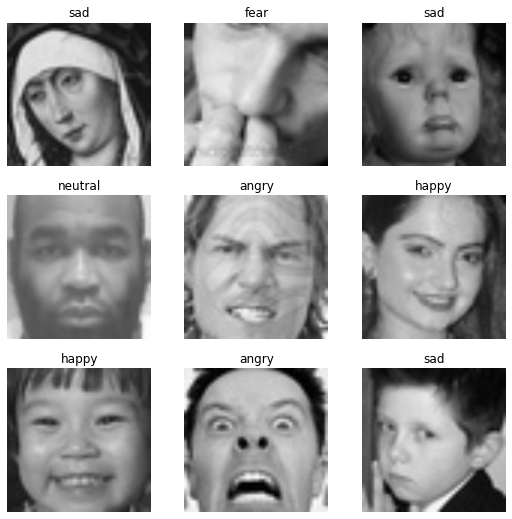

In [35]:
dls.show_batch()

## Import CNN model

In [7]:
# Choose model
arch_model = models.resnet50

In [8]:
# Build TL model based on arch
learning_model = cnn_learner(dls, arch_model, metrics=[accuracy, error_rate])

In [10]:
# learning_model.model

In [11]:
# Labels counter
# from collections import Counter
# labels_count = Counter(label for label in df['Label'])
# labels_count

In [12]:
# Get Class Weights --> This will allow us to compensate the classes with less data
# total_count = sum(labels_count.values())
# class_weights = {cls: total_count / count for cls, count in labels_count.items()}
# class_weights

In [13]:
# weights = [*class_weights.values()]
# class_weights=torch.FloatTensor(weights).cuda()
# learning_model.crit = nn.CrossEntropyLoss(weight=class_weights)

## Training stage 1

In [9]:
# LR Finder helps to pick a good learning rate
learning_model.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 900.00 MiB (GPU 0; 5.93 GiB total capacity; 3.60 GiB already allocated; 818.31 MiB free; 4.24 GiB reserved in total by PyTorch)

In [15]:
# Train
learning_model.fit_one_cycle(10, 1e-02)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.402995,1.271033,0.527608,0.472392,04:07
1,1.290028,1.355443,0.504093,0.495907,04:07
2,1.148723,1.307195,0.514893,0.485107,04:07
3,1.079139,1.022520,0.614701,0.385299,04:03
4,0.975726,1.004829,0.624804,0.375196,03:59
5,0.902131,0.942592,0.644313,0.355687,04:02
6,0.748633,0.938258,0.660686,0.339314,04:05
7,0.666318,0.953494,0.658422,0.341578,04:00


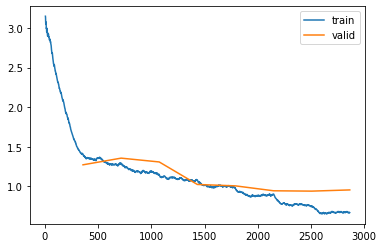

In [16]:
# Plot losses
learning_model.recorder.plot_loss()

In [17]:
# Save stage 1
# model_name = "resnet50_stage1_noNORM_184"
# learning_model.save(root_path / model_name)

## Training stage 2

SuggestedLRs(lr_min=6.918309736647643e-07, lr_steep=5.754399353463668e-06)

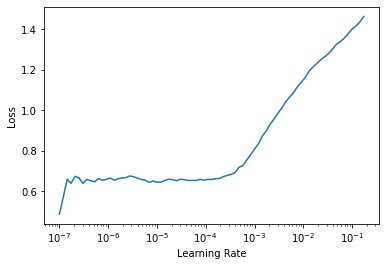

In [18]:
# Unfreeze
learning_model.unfreeze()

# Find LR
learning_model.lr_find()

In [19]:
# Train
learning_model.fit_one_cycle(10, (slice(1e-6, 1e-4)))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.648345,0.956039,0.658073,0.341926,04:55
1,0.644985,0.966267,0.659119,0.340881,04:57
2,0.568711,1.008308,0.662254,0.337746,04:54
3,0.481824,1.053207,0.657028,0.342972,04:53
4,0.358614,1.139539,0.649538,0.350462,05:00
5,0.246062,1.195201,0.649364,0.350636,04:59
6,0.181011,1.283300,0.644487,0.355513,05:00
7,0.135645,1.317081,0.651629,0.348371,05:02


KeyboardInterrupt: 

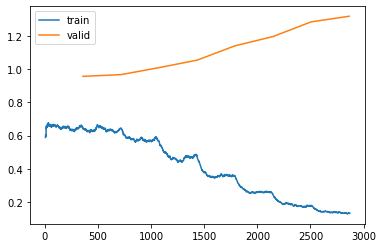

In [20]:
# Plot losses
learning_model.recorder.plot_loss()

In [ ]:
# Save stage 2
# model_name = "resnet50_stage2_noNORM_184"
# learning_model.save(root_path / model_name)

# Testing

In [21]:
# Images Path
path_to_test = Path('/home/roldanx/code/artificial_intelligence/ownAI/fastai_faces/faces/test')

# Generate dataset
filelist = [relpath(os.path.join(dp, f), path_to_test) for dp, dn, filenames in os.walk(path_to_test) for f in filenames]
data_tuples = list(zip(filelist, [x.split("/")[0] for x in filelist]))
df_test = pd.DataFrame(data_tuples, columns=['Path', 'Label'])
df_test

,Path,Label
0,angry/PublicTest_14075653.jpg,angry
1,angry/PrivateTest_73860110.jpg,angry
2,angry/PublicTest_18274972.jpg,angry
3,angry/PublicTest_14798104.jpg,angry
4,angry/PublicTest_51080774.jpg,angry
...,...,...
7173,surprise/PublicTest_17911043.jpg,surprise
7174,surprise/PublicTest_83231837.jpg,surprise
7175,surprise/PrivateTest_95778572.jpg,surprise
7176,surprise/PrivateTest_81533064.jpg,surprise


In [22]:
df_test.sample(frac=1)

,Path,Label
1542,happy/PrivateTest_64421357.jpg,happy
4776,fear/PublicTest_51722533.jpg,fear
4010,sad/PublicTest_50385779.jpg,sad
1920,happy/PublicTest_13788513.jpg,happy
73,angry/PublicTest_33049665.jpg,angry
...,...,...
601,angry/PublicTest_52739184.jpg,angry
3650,sad/PublicTest_10760798.jpg,sad
5121,neutral/PublicTest_9076186.jpg,neutral
6116,neutral/PublicTest_35641560.jpg,neutral


In [23]:
# Generate test_dataloader
dls_test = ImageDataLoaders.from_df(df_test, path_to_test, valid_pct=0.2, label_col=1, bs=64, item_tfms=Resize(184))

In [ ]:
# learning_model.__dict__

In [24]:
# Switch train_dataloader to test_dataloader 
test_model = learning_model
test_model.dls = dls_test
test_model.validate()

(#3) [3.9237184524536133,0.22648084163665771,0.7735191583633423]

In [ ]:
test_model.predict(path_to_test/df_test["Path"].iloc[0])

In [ ]:
path_to_test/df_test["Label"].iloc[0]

In [ ]:
test_model.dls = dls
test_model.validate()

In [ ]:
# test_model.dls = dls
# arr = test_model.validate()
# print(arr[1])

In [ ]:
interp = ClassificationInterpretation.from_learner(test_model)
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [ ]:
test_model.show_results()